# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [2]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.6904114811574404
 0.7830994865465055
 0.24537267049973366
 0.9981401116153796
 0.7538790531745837
 0.11128993905200169
 0.6817745870304239
 0.3915406100246336
 0.9338011161971024
 0.12208619469894033
 ⋮
 0.05599110392771611
 0.43594552483199545
 0.09704485272550689
 0.08504507624731861
 0.42456427940906494
 0.9701174237624945
 0.09904724227545292
 0.2421248509876659
 0.7674906702735368

In [3]:
sum(a)

4.998080118547495e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [4]:
@time sum(a)

  0.002763 seconds (1 allocation: 16 bytes)


4.998080118547495e6

In [5]:
@time sum(a)

  0.002733 seconds (1 allocation: 16 bytes)


4.998080118547495e6

In [6]:
@time sum(a)

  0.002200 seconds (1 allocation: 16 bytes)


4.998080118547495e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [7]:
 using Pkg
 Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [8]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [10]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [11]:
c_sum(a)

4.998080118547292e6

In [12]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [13]:
c_sum(a) - sum(a)  

-2.0302832126617432e-7

In [ ]:
≈  # alias for the `isapprox` function

We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 527 samples with 1 evaluation.
 Range (min … max):  9.384 ms …  9.777 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.487 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.490 ms ± 60.141 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃   █▄▅▁▅▅▂▄▁▇▅▁▃▁▅▄ ▃  █▃▅▄▄▁█▄▅▃▁                       
  ▄▃█▅▆▇████████████████▇██████████████▆▄▇▅▃▃▃▇▃▃▃▃▅▃▃▁▁▁▁▃▃ ▅
  9.38 ms        Histogram: frequency by time        9.66 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.393625 msec


In [15]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.38358

In [16]:
using Plots
gr()

Plots.GRBackend()

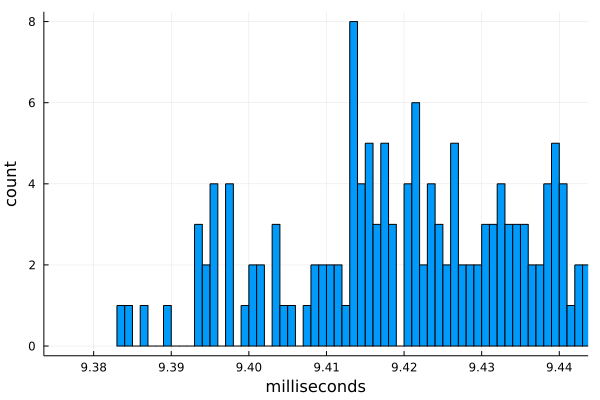

In [17]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [18]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [19]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 2728 samples with 1 evaluation.
 Range (min … max):  1.780 ms …  4.154 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.807 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.823 ms ± 63.692 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▅▃                                                        
  ▄███▇▅▅▆▆▅▄▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂ ▃
  1.78 ms        Histogram: frequency by time           2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [20]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.779875

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [21]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [22]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [23]:
pysum(a)

4.998080118547292e6

In [24]:
pysum(a) ≈ sum(a)

true

In [25]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  850.908 ms …    1.642 s  ┊ GC (min … max): 19.20% … 30.57%
 Time  (median):        1.252 s               ┊ GC (median):    24.05%
 Time  (mean ± σ):      1.206 s ± 324.637 ms  ┊ GC (mean ± σ):  23.82% ±  4.96%

  █    █                        █        █                    █  
  █▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  851 ms           Histogram: frequency by time          1.64 s <

 Memory estimate: 152.60 MiB, allocs estimate: 10000049.

In [26]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38358
  "Python built-in" => 850.908
  "C -ffast-math"   => 1.77988

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...


    Updating `~/.julia/environments/v1.7/Project.toml`
  [8f4d0f93] + Conda v1.7.0
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [31]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/sergio/.julia/packages/Conda/x2UxR/src/Conda.jl:127


done
Solving environment: ...working... 

done



# All requested packages already installed.

Retrieving notices: ...working... 

done


In [32]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

PyCall.PyError: PyError (PyImport_ImportModule

The Python package numpy could not be imported by pyimport. Usually this means
that you did not install numpy in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the numpy module, you can
use `pyimport_conda("numpy", PKG)`, where PKG is the Anaconda
package that contains the module numpy, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <class 'ImportError'>
ImportError('\n\nIMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!\n\nImporting the numpy C-extensions failed. This error can happen for\nmany reasons, often due to issues with your setup or how NumPy was\ninstalled.\n\nWe have compiled some common reasons and troubleshooting tips at:\n\n    https://numpy.org/devdocs/user/troubleshooting-importerror.html\n\nPlease note and check the following:\n\n  * The Python version is: Python3.9 from "/Users/sergio/.julia/conda/3/bin/python"\n  * The NumPy version is: "1.21.1"\n\nand make sure that they are the versions you expect.\nPlease carefully study the documentation linked above for further help.\n\nOriginal error was: dlopen(/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so, 0x0002): tried: \'/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so\' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64)))\n')
  File "/Users/sergio/.local/lib/python3.9/site-packages/numpy/__init__.py", line 150, in <module>
    from . import core
  File "/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/__init__.py", line 48, in <module>
    raise ImportError(msg)


In [33]:
numpy_sum(a)

UndefVarError: UndefVarError: numpy_sum not defined

In [30]:
numpy_sum(a) ≈ sum(a)

true

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 11.063
  "Python numpy"    => 6.64861
  "Python built-in" => 904.664
  "C -ffast-math"   => 6.95261

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x11c844ee0>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.100 s …    1.890 s  ┊ GC (min … max): 13.92% … 26.63%
 Time  (median):     1.336 s               ┊ GC (median):    16.94%
 Time  (mean ± σ):   1.416 s ± 355.403 ms  ┊ GC (mean ± σ):  19.59% ±  6.19%

  █     █                    █                             █  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.1 s          Histogram: frequency by time         1.89 s <

 Memory estimate: 152.60 MiB, allocs estimate: 10000049.

In [37]:
sum_py(a)

4.998080118547292e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                   => 9.38358
  "Python hand-written" => 1099.93
  "Python built-in"     => 850.908
  "C -ffast-math"       => 1.77988

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [40]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [41]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 2627 samples with 1 evaluation.
 Range (min … max):  1.825 ms …  3.686 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.862 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.893 ms ± 99.067 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▆▄▂                                                       
  ██████▆▇▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▂▁▂▂ ▃
  1.83 ms        Histogram: frequency by time         2.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38358
  "Python hand-written" => 1099.93
  "Python built-in"     => 850.908
  "Julia built-in"      => 1.82533
  "C -ffast-math"       => 1.77988

# 7. Julia (hand-written) 

In [43]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [44]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 526 samples with 1 evaluation.
 Range (min … max):  9.390 ms …  9.834 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.493 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.497 ms ± 64.465 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▂▄▃▅▂ ▁ ▁▂▁▆▃▃▆▁▄ ▃▁█▄▂▆▄▁▂▃                           
  ▇▃▇▇█████████████████████████████▇▅█▆▅▇▆▄▄▃▃▁▃▁▁▃▃▃▃▃▃▅▃▃▃ ▅
  9.39 ms        Histogram: frequency by time        9.67 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.38358
  "Julia hand-written"  => 9.39042
  "Python hand-written" => 1099.93
  "Python built-in"     => 850.908
  "Julia built-in"      => 1.82533
  "C -ffast-math"       => 1.77988

# 8. Julia (hand-written w. simd) 

In [46]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [47]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 2078 samples with 1 evaluation.
 Range (min … max):  2.358 ms …  2.631 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.388 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.397 ms ± 33.904 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▁▂▄                                                       
  ▃█████▆▅▆▅▆▅▅▆▆▅▅▅▄▃▃▄▄▃▄▄▃▃▃▂▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  2.36 ms        Histogram: frequency by time        2.51 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
mysum_simd(a)

4.9980801185475625e6

In [49]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written simd" => 2.35833
  "C"                       => 9.38358
  "Julia hand-written"      => 9.39042
  "Python hand-written"     => 1099.93
  "Python built-in"         => 850.908
  "Julia built-in"          => 1.82533
  "C -ffast-math"           => 1.77988

# Summary

In [48]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................6.6
C -ffast-math...............7.0
Julia built-in..............7.4
Julia hand-written simd.....7.6
C..........................11.1
Julia hand-written.........11.3
Python built-in...........904.7
Python hand-written......1174.9
